# 3. PCA
We consider the thickness data only. Then we normalize it, with a good norm. 
Afterwards we create two matrices, that will each of them represent the spaces of label 0 and 1:
- Matrix 0: concatenation of the vectors of the thickness data, with label 0
- Matrix 1: same but with label 1. 

In [14]:
import sys
import os
from skimage import exposure
import pandas as pd 
import numpy as np 
import cv2
import glob
from helpers import *
import matplotlib.pyplot as plt
from buildDataset import *
%matplotlib inline
from warnings import warn
from sklearn.decomposition import PCA, KernelPCA, NMF
from sklearn.manifold import TSNE

X_stacked, y = getBalancedStackedXYData(normmode=None, normmode_thick=None)



In [15]:
xmin = 70
xmin_thick = 6

X = X_stacked[:, -xmin_thick:]
print(X.shape)
print(y.shape)
print(X[389:,:])
print("Min=", X.min())
print("max=", X.max())

(193536, 6)
(193536,)
[[50.  4. 11. 13. 30. 18.]
 [50.  4. 11. 13. 30. 18.]
 [49.  5. 12. 12. 30. 18.]
 ...
 [62. 15. 10. 12. 14. 13.]
 [62. 15. 10. 12. 14. 13.]
 [62. 15. 10. 12. 14. 13.]]
Min= 0.0
max= 108.0


In [16]:
X_train, y_train = X[:768*15*14,:].T, y[:768*15*14].T
X_valid, y_valid = X[768*15*14:,:].T, y[768*15*14:].T

normmode='EUCLID-std'
#normmode='std'

print("training set:", X_train.shape[0])
print("validation set:", X_valid.shape[0])

params = {
    'n_components': 2,
    'max_iter': 1000,
    'init': 'nndsvd'
}
params = {
    'n_components': 2,
}
pca0, pca1 = train_dim_red(X_train, y_train, normmode, dimred_model= PCA, params=None, alpha=0.1)


training set: 6
validation set: 6
training set: 6
Norm mode: EUCLID-std


IndexError: boolean index did not match indexed array along dimension 0; dimension is 6 but corresponding boolean dimension is 161280

In [8]:
M0, M1 = getLabelledMatrices(X_train, y_train, normmode)
print("M0.shape:", M0.shape)
print("M1.shape:", M1.shape)
print(M0.shape[0] + M1.shape[0])

M0.shape: (136316, 6)
M1.shape: (24964, 6)
161280


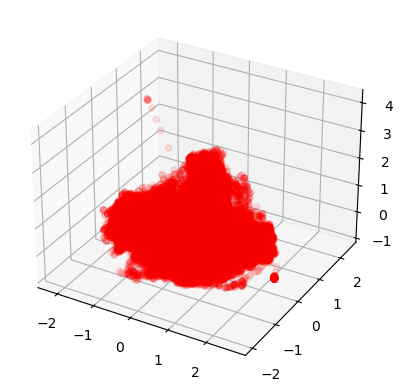

In [9]:
# plot in 3d
M0_t = pca0.fit_transform(M0)
fig=plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(M0_t[:,0], M0_t[:,1], M0_t[:,2], c='r', alpha=0.1 )

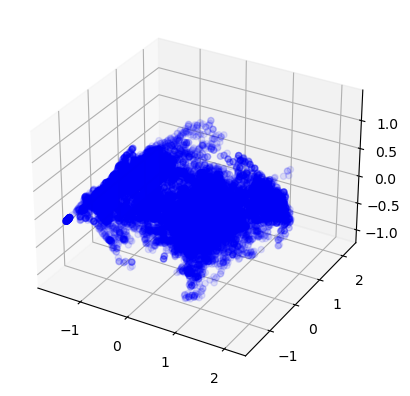

In [10]:
# plot in 3d
M1_t = pca1.fit_transform(M1)
fig=plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(M1_t[:,0], M1_t[:,1], M1_t[:,2], c='b', alpha=0.1 )

### Validation set


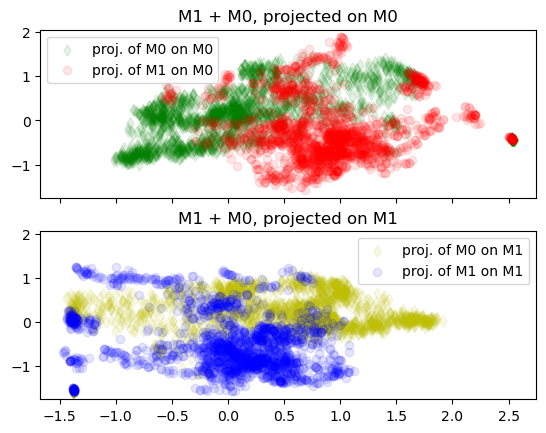

In [11]:
plot_validation(X_valid, y_valid, normmode, pca0, pca1)

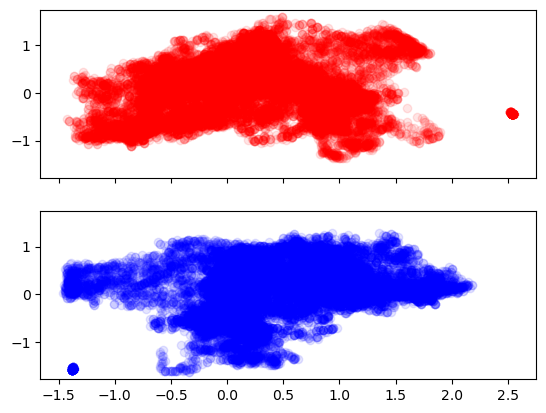

In [12]:
M0_valid, M1_valid = getLabelledMatrices(X_valid, y_valid, normmode)

M0_valid_t0 = pca0.transform(M0_valid)
M0_valid_t1 = pca1.transform(M0_valid)

M1_valid_t1 = pca1.transform(M1_valid)
M1_valid_t0 = pca0.transform(M1_valid)

fig, axes = plt.subplots(2,1, sharey=True, sharex=True)
axes[0].scatter(M0_valid_t0[:,0], M0_valid_t0[:,1], c='r', alpha=0.1)
axes[1].scatter(M0_valid_t1[:,0], M0_valid_t1[:,1], c='b', alpha=0.1)

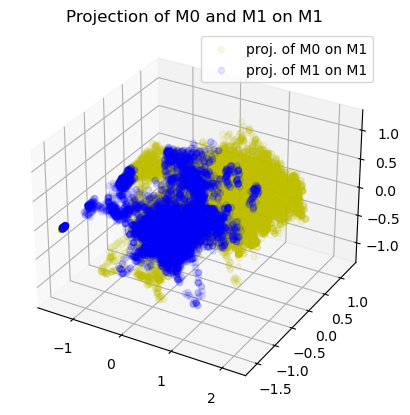

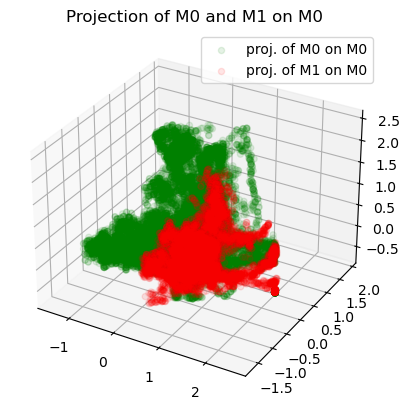

In [13]:
plot_3D(X_valid, y_valid, normmode, pca0, pca1)

### 3.1 visualize SVM 
With NMF, Euclidean norm

In [9]:
from sklearn import svm

def plot_SVM(X, y, model, title = ''):
    """
    Plot svm on the validation data to visualize the separation of the data. 
    INPUT: 
    - X: data, projected on the 2D reduced space. 
    - y: labels, projected on the reduced space.

    """
    h = .02  # step size in the mesh

    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.show()

training set: 161280
Norm mode: EUCLID
M0.shape: (136316, 6)
M1.shape: (24964, 6)
M0.shape + M1.shape: 161280
LABEL 0:
components:
 [[36.09613098  2.69097766  0.          1.36411376  5.03758936  6.31546484]
 [ 0.          4.41506765 25.81702394 18.82430297 18.66241935 11.017931  ]]
M0_t.shape: (136316, 2)

LABEL 1:
components:
 [[21.75529367  0.42291296  0.          0.79746051  8.79428169  4.80769468]
 [ 0.85656762  3.51903209 15.29603933 11.87161104  0.          4.31844302]]
M1_t.shape: (24964, 2)


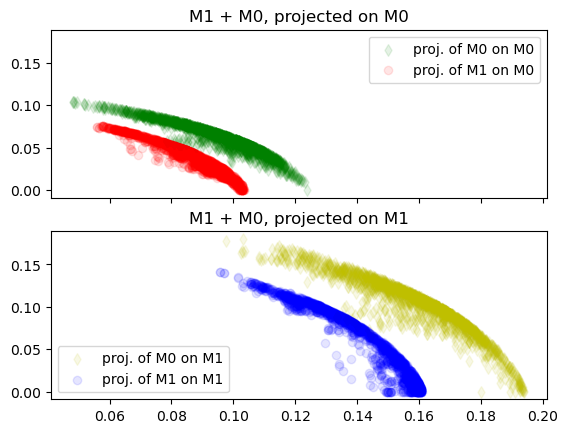

In [13]:
normmode='EUCLID'
# data
X_train, y_train = X[:768*15*14,:], y[:768*15*14]
X_valid, y_valid = X[768*15*14:,:], y[768*15*14:]

# models 
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C)
# title for the plots
title = ['SVC with linear kernel']

# dimred model
dimred_model = NMF
params = {
    'n_components': 2,
    'max_iter': 1000,
    'init': 'nndsvd'
}

dimred0, dimred1 = train_dim_red(X_train, y_train, normmode, dimred_model, params=params, alpha=0.1)


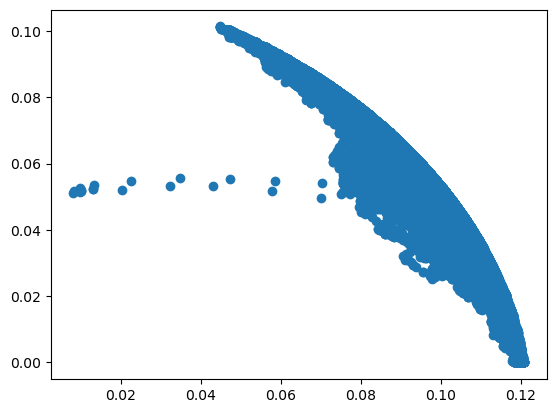

In [14]:
X_valid_norm =  NormalizeThickness(NormalizeThickness(X_valid, 'EUCLID'), 'std')
X_train_norm = NormalizeThickness(NormalizeThickness(X_train, 'EUCLID'), 'std')
X_valid_t0, X_train_t0 = dimred0.transform(X_valid_norm), dimred0.transform(X_train_norm)
plt.scatter(X_train_t0[:, 0], X_train_t0[:, 1])

In [ ]:
print("training...")
svc.fit(X_train_t0, y_train) #takes about 5 min

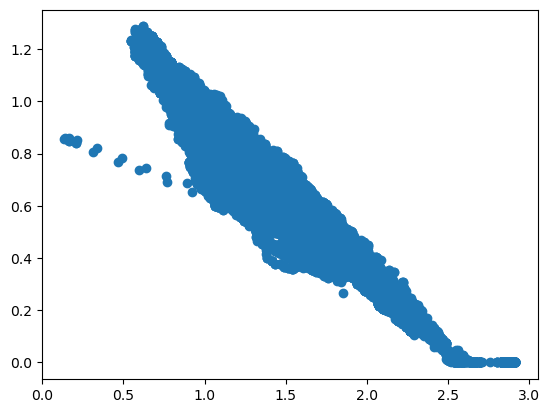

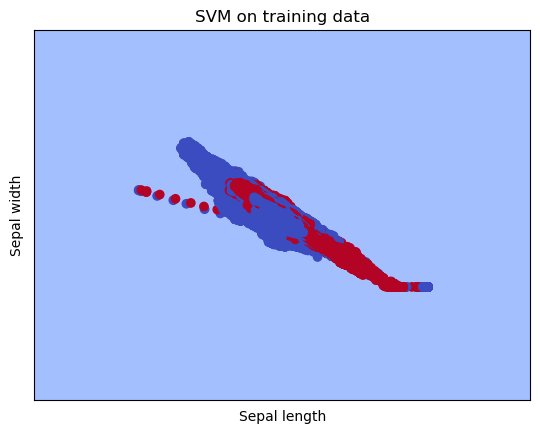

In [8]:
plot_SVM(X_train_t0, y_train, svc, title = 'SVM on training data')

In [ ]:
plot_SVM(X_valid_t0, y_valid, svc, title = 'SVM on validation data')

In [ ]:
normmode='EUCLID'

# models 
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C)
lin_svc = svm.LinearSVC(C=C)
models = [svc, rbf_svc, poly_svc, lin_svc]

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']

# dimred model
dimred_model = NMF
params = {
    'max_iter': 1000,
    'init': 'nndsvd'
}

pca0, pca1 = train_dim_red(X_train, y_train, normmode, dimred_model, params=None, alpha=0.1)